In [1]:
import pandas as pd
from hoki import load
import matplotlib.pyplot as plt 
import numpy as np
import gc

plt.style.use('hfs')

# Searching for NGC 1850-BH1 in BPASS 

This jupyter notebook provides all of the code required to reproduce the analysis of [Stevance et al. 2022](https://arxiv.org/abs/2112.00015). We provide these resources openly to promote reproducibility and as a learnign tool for our peers - if you use this code as a starting point for your own scientific analysis, we would be grateful if you could **acknowledge this notebook** in the acknowledgment section of your paper and **cite any relevant references** mentioned along the way. 

## 1. Loading in data

### 1.1 Observations

The NGC 1850 was obtained through private communications with the authors of [Saracino et al. 2021](https://arxiv.org/abs/2111.06506). If you make use of this workflow and data for your work please cite their paper as well and for the full data please contact the authors of the original paper.

- We first load in the photometric data of our system of interest:

In [44]:
# selecting the system with the BH candidate (ID = 224, private communication with Chris Usher)
phot_system =  pd.read_csv('ngc1850bh1.dat')

- The BPASS synthetic photometry provides aboslute magnitudes, so we need to take the distance modulus into account

In [3]:
# Distance modulus 
mu = 18.45

# Getting absolute magnitudes 
phot_system.loc[:, 'f336w'] -= mu
phot_system.loc[:, 'f438w'] -= mu
phot_system.loc[:, 'f814w'] -= mu

/home/fste075/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [4]:
phot_system

,id,snr,f336w,f336w_err,f438w,f438w_err,f814w,f814w_err
205,224,1183.1,-2.537,0.002,-1.749,0.004,-1.88,0.003


### 1.2 BPASS models

The full BPASS stellar library is 50GB so we provide a cropped data set which has been reduced using hoki ([Stevance et al. 2020](https://ui.adsabs.harvard.edu/abs/2020JOSS....5.1987S/abstract)).
The pickle file contains a pandas DataFrame with models which fit the following criteria:
- Z = 0.010 
- M1$_{\rm zams}$ > 0.5 M$_{\odot}$ (mass of the bright component)
- age < 500 Myrs 

The full dataframe (without the above conditions) is `models_z010_bin_v221.pkl` and was released with the dataset available on [Zenodo](https://zenodo.org/record/4064300#.YdIRf3VBzmE). 


In [5]:
def log_g(M, logR):
    return np.log10((6.67259 * 10 ** (-8)) * (1.989 * 10 ** 33) * M / (((10 ** logR * 6.9598 * (10 ** 10)) ** 2)))

## Loading in the dataframe
data_crop = pd.read_pickle('models_z010_bin_M1zams_gt_05_age_less_5e8.pkl')

## The periods in BPASS are given in years, we turn them into days
data_crop.P_bin = data_crop.P_bin.astype(float)*365.25

data_crop['log_g1']=log_g(data_crop.M1, data_crop['log(R1)'])

In [6]:
## Isolating the columns we need
data_crop = data_crop[['age',
                       'M1', 
                       'M2', 
                       'P_bin', 
                       'f336w', 
                       'f814w', 
                       'log(T1)',  
                       'log(R1)', 
                       'log(T2)', 
                       'log(R2)',
                       'modelimf', 
                       'mixedimf', 
                       'types', 
                       'log_g1',
                       'B',
                       'V',
                       'R',
                       'filenames'
                      ]]

# Model search

## Search 1: Looking for NGC1850-BH1 as in Saracino et al. 2021

In [7]:
data_search1 = data_crop[  (data_crop.age>=0.8e8) # Wide age range
                         & (data_crop.age<=3.0e8)
                         & (data_crop.M1>=3) # Bright component mass
                         & (data_crop.M1<=7)
                         & (data_crop.P_bin>3)# Periods
                         & (data_crop.P_bin<7)
                         & (data_crop.types==2) # secondary star evolution (primary already "died")
                         & (data_crop.M2>=5) # BH mass
                        ]
data_search1.age/=1e6

/home/fste075/.local/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [8]:
data_search1

,age,M1,M2,P_bin,f336w,f814w,log(T1),log(R1),log(T2),log(R2),modelimf,mixedimf,types,log_g1,B,V,R,filenames
2060573,98.19045,3.30256,5.672905,3.012423,-0.374835,-1.662275,3.78358,1.12186,3.44493,0.0,0.028298,0.0,2,2.712866,-0.592221,-1.087646,-1.461609,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-5-...
2060574,98.19305,3.20946,5.765906,3.125814,-0.148935,-1.574548,3.76839,1.12907,3.44493,0.0,0.028298,0.0,2,2.686028,-0.386121,-0.943620,-1.354744,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-5-...
2060575,98.19564,3.11659,5.858851,3.253879,0.007787,-1.524926,3.75873,1.13498,3.44493,0.0,0.028298,0.0,2,2.661455,-0.253530,-0.855897,-1.292327,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-5-...
2060576,98.19870,3.00786,5.967791,3.425380,0.121966,-1.495575,3.75103,1.14256,3.44493,0.0,0.028298,0.0,2,2.630873,-0.167497,-0.800210,-1.254083,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-5-...
2060731,98.28766,3.96183,5.013867,4.006204,-1.408296,-2.486675,3.82044,1.23025,3.44493,0.0,0.048002,0.0,2,2.575132,-1.706965,-2.058240,-2.335828,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-5-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155510,98.32927,4.79478,6.509142,6.513269,-2.612597,-3.230995,3.90447,1.27134,3.44493,0.0,0.206297,0.0,2,2.575824,-3.051607,-3.112895,-3.184526,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-5-...
2155511,98.33641,4.72849,6.575454,6.587726,-2.469956,-3.221777,3.88569,1.29197,3.44493,0.0,0.206297,0.0,2,2.528518,-2.939062,-3.047636,-3.155597,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-5-...
2155512,98.34236,4.65721,6.646802,6.675404,-2.335055,-3.203084,3.86695,1.31132,3.44493,0.0,0.206297,0.0,2,2.483222,-2.794557,-2.963633,-3.114915,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-5-...
2155513,98.34769,4.57769,6.726403,6.782974,-2.195944,-3.174644,3.84715,1.33059,3.44493,0.0,0.206297,0.0,2,2.437202,-2.610783,-2.857766,-3.061010,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-5-...


In [9]:
data_search1.filenames.unique().shape

(13,)

### Comparing our models to NGC1850-BH1

There are 13 matching models in total, the number size of the dataframe (340) includes each tiemstep at which these models match our criteria - since they might gain and lose mass over time they might come in or out of the matching range. Some systems will spend longer within the range than others, and some systems will be much more likely to occur than others due to the IMF. 

A first order visualisation is to use the `modelimf` column to apply a grey scale to our plot of M1 Vs M2 - the darker the point, the more likely this combination of M1-M2. As we can see below NGC1850-BH1 is not found in our search.

Text(4.36, 11, 'NGC1850-BH1')

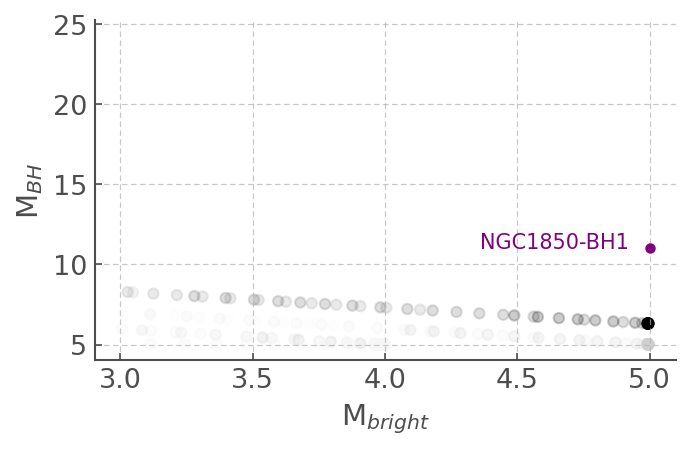

In [10]:
cb = plt.scatter(data_search1.M1, data_search1.M2, 
                 c=data_search1.modelimf, cmap='Greys', alpha=0.2, marker='o')

plt.xlabel('M$_{bright}$')
plt.ylabel('M$_{BH}$')

plt.plot([5], [11], ls=' ', marker='o', color='purple')
plt.text(4.36, 11, "NGC1850-BH1", color='purple')

We can groub by M1-M2 and sort by modelimf to find the best combination of masses

In [11]:
data_search1.groupby(['M1', 'M2']).sum().sort_values('modelimf', ascending=False)['modelimf'].head(5)

M1       M2     
4.99375  6.30957    0.705961
4.99376  6.30957    0.705961
4.99372  6.30957    0.412594
4.99569  6.30957    0.352980
4.99383  6.30957    0.352980
Name: modelimf, dtype: float64

## Search 2: Looking for NGC1850-BH1 with El-Bardy constraints

In [12]:
data_current_age = data_crop[(data_crop.age>=0.8e8) & (data_crop.age<=1.2e8)]

In [13]:
FUDGE = 1 # error bar window for the absolute magnitude
f336_lo = (phot_system.f336w-phot_system.f336w_err-FUDGE).values[0]
f336_hi = (phot_system.f336w+phot_system.f336w_err+FUDGE).values[0]

f814_lo = (phot_system.f814w-phot_system.f814w_err-FUDGE).values[0]
f814_hi = (phot_system.f814w+phot_system.f814w_err+FUDGE).values[0]

FUDGE_P = 2 # error bar window for the period
P_lo = 5.04 - FUDGE
P_hi = 5.04 + FUDGE 

# magnitude constraints
condition1 = (data_current_age.f336w.values > f336_lo) & (data_current_age.f336w.values < f336_hi)
condition2 = (data_current_age.f814w.values > f814_lo) & (data_current_age.f814w.values < f814_hi)
# period contraints
condition3 = (data_current_age.P_bin > P_lo) & (data_current_age.P_bin < P_hi)
# mass constraints (El Bardy & Brudge)
condition4 = (data_current_age.M2 >=2)&(data_current_age.M2 <6)
condition5 = (data_current_age.M1 <=2) & (data_current_age.M1 >0.5)
condition6 = data_current_age.M1 <data_current_age.M2 #  otherwise RV definitely wrong
condition7 = data_current_age.types==2

In [14]:
data_search2 = data_current_age[  condition1 
                                & condition2 
                                & condition3 
                                & condition4
                                & condition5
                                & condition6
                                & condition7
                               ]
data_search2.age/=1e6

/home/fste075/.local/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [15]:
data_search2

,age,M1,M2,P_bin,f336w,f814w,log(T1),log(R1),log(T2),log(R2),modelimf,mixedimf,types,log_g1,B,V,R,filenames
1942485,81.10234,0.89635,2.554929,4.899321,-3.382708,-1.335633,4.80418,0.07925,3.44493,0.0,0.047072,0.0,2,4.231713,-1.731224,-1.399315,-1.384676,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-6-...
1942486,81.10239,0.89634,2.554929,4.899347,-3.369800,-1.324285,4.80694,0.07378,3.44493,0.0,0.047072,0.0,2,4.242648,-1.718281,-1.386421,-1.372717,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-6-...
1942487,81.10239,0.89634,2.554929,4.899347,-3.369800,-1.324285,4.80694,0.07378,3.44493,0.0,0.047072,0.0,2,4.242648,-1.718281,-1.386421,-1.372717,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-6-...
1942657,80.30528,1.15594,2.259553,5.426077,-3.427124,-1.182224,4.54519,0.30828,3.44493,0.0,0.048631,0.0,2,3.884111,-1.712385,-1.448577,-1.312300,NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-6-...


In [16]:
data_search2.filenames.unique()

array(['NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-6-1.99526-1.00000',
       'NEWBINMODS/NEWSECMODS/z010_2/sneplot_2-z010-6-1.99526-1.20000'],
      dtype=object)

There are therefore 2 matching models, the first 3 rows are very similar ages and essentially the same stellar properties. This table corresponds to Table 1 in the paper (although the first 3 rwos have been collapsed to 1)

Note that the MODEL ID is a new way to identify the BPASS models and the hoki features to which it is relevant are not publically available yet, but the tables in this notebook and in the paper are in the same order so the MODEL ID is not relevant at this time. 

### Lifetime of the phases which match observations - ONLY RUN IF YOU HAVE THE STELLAR LIBRARIES

#### **/!\ WARNING /!\**

You will only be able to run the following code if you have the original stellar libraries downloaded - you can download the file `bpass-v2.2-newmodels.tar.gz` [here](https://drive.google.com/drive/folders/1BS2w9hpdaJeul6-YtZum--F4gxWIPYXl).
You can set up your `MODELS_PATH` in hoki using the function `load.set_models_path()`, or jsut replace `load.MODELS_PATH` below by the path to your local BPASS stellar library.


**Note the ages here are in years, not Myrs**

In [17]:
dat1 = load.dummy_to_dataframe(load.MODELS_PATH+data_search2.filenames.iloc[0])
dat1[['age', 'M1', 'M2', 'log(T1)', 'P_bin',  'f336w', 'f814w']].tail(5)

,age,M1,M2,log(T1),P_bin,f336w,f814w
199,81101310.0,0.89655,2.554929,4.74273,0.013412,-3.726676,-1.620189
200,81101840.0,0.89645,2.554929,4.77342,0.013413,-3.565104,-1.488226
201,81102340.0,0.89635,2.554929,4.80418,0.013414,-3.382708,-1.335633
202,81102390.0,0.89634,2.554929,4.80694,0.013414,-3.369800,-1.324285
203,81102390.0,0.89634,2.554929,4.80694,0.013414,-3.369800,-1.324285


This system only matches our criteria for the last 40 years of its life. 

In [18]:
dat2 = load.dummy_to_dataframe(load.MODELS_PATH+data_search2.filenames.iloc[-1])
dat2[['age', 'M1', 'M2', 'log(T1)', 'P_bin',  'f336w', 'f814w']].iloc[167:172]

,age,M1,M2,log(T1),P_bin,f336w,f814w
167,80270880.0,1.15636,2.259553,4.61028,0.014852,-2.833263,-0.537147
168,80288630.0,1.15615,2.259553,4.58004,0.014854,-3.121964,-0.850704
169,80305280.0,1.15594,2.259553,4.54519,0.014856,-3.427124,-1.182224
170,80320480.0,1.15572,2.259553,4.50542,0.014858,-3.741417,-1.521360
171,80332550.0,1.15553,2.259553,4.46595,0.014859,-3.994971,-1.827803


In [19]:
80320480.0-80305280 # take the delta t between matching bins and the next one. 

15200.0

This system only matches the criteria for 15,200 years

## Search 3: Looking for best match to observations

This is section 2.2 of the paper

In [20]:
FUDGE=0.8
f336_lo = (phot_system.f336w-phot_system.f336w_err-FUDGE).values[0]
f336_hi = (phot_system.f336w+phot_system.f336w_err+FUDGE).values[0]

f814_lo = (phot_system.f814w-phot_system.f814w_err-FUDGE).values[0]
f814_hi = (phot_system.f814w+phot_system.f814w_err+FUDGE).values[0]

FUDGE_P = 2 #1.5 days
P_lo = 5.04- FUDGE
P_hi = 5.04 + FUDGE 

T_lo = np.log10(10000)
T_hi = np.log10(20000)

# magnitude constraints
condition1 = (data_current_age.f336w.values > f336_lo) & (data_current_age.f336w.values < f336_hi)
condition2 = (data_current_age.f814w.values > f814_lo) & (data_current_age.f814w.values < f814_hi)
# period contraints
condition3 = (data_current_age.P_bin > P_lo) & (data_current_age.P_bin < P_hi) 
# mass constraints (El Bardy & Brudge)
condition4 = (data_current_age.M2 >=2)&(data_current_age.M2 <6)
condition5 = (data_current_age.M1 <=2) & (data_current_age.M1 >0.5)
condition6 = (data_current_age.M1 < data_current_age.M2) # otherwise RV definitely wrong
# Temperature constraints - form original paper
condition7 = (data_current_age['log(T1)']>T_lo) & (data_current_age['log(T1)']<T_hi)

In [21]:
data_search3 = data_current_age[  condition1 
                                & condition2 
                                & condition3 
                                & condition4
                                & condition5
                                & condition6
                                & condition7
                               ]
data_search3.age/=1e6

/home/fste075/.local/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [22]:
data_search3

,age,M1,M2,P_bin,f336w,f814w,log(T1),log(R1),log(T2),log(R2),modelimf,mixedimf,types,log_g1,B,V,R,filenames
785107,84.17926,1.62442,3.175703,4.451199,-2.285956,-1.876484,4.03156,0.86722,3.90344,0.27211,2.875204,0.0,1,2.913994,-1.990652,-1.917188,-1.898039,NEWBINMODS/NEWBINMODS/z010/sneplot-z010-6-0.3-0.2
785108,84.41889,1.51924,3.236406,4.829167,-2.344947,-1.956485,4.02810,0.88649,3.90117,0.27666,2.875204,0.0,1,2.846382,-2.065517,-1.993789,-1.976508,NEWBINMODS/NEWBINMODS/z010/sneplot-z010-6-0.3-0.2
785109,84.60834,1.40573,3.284027,5.240260,-2.385274,-2.038569,4.02236,0.90782,3.89942,0.28018,2.875204,0.0,1,2.769998,-2.139755,-2.070948,-2.056251,NEWBINMODS/NEWBINMODS/z010/sneplot-z010-6-0.3-0.2
785110,84.76026,1.27463,3.321985,5.736701,-2.393425,-2.111510,4.01309,0.93154,3.89804,0.28295,2.875204,0.0,1,2.680040,-2.200572,-2.136524,-2.125552,NEWBINMODS/NEWBINMODS/z010/sneplot-z010-6-0.3-0.2
785269,85.98281,1.69785,4.329369,4.709687,-2.269250,-1.950836,4.01925,0.88435,3.99148,0.35145,2.784498,0.0,1,2.898935,-2.058397,-1.990123,-1.970666,NEWBINMODS/NEWBINMODS/z010/sneplot-z010-6-0.4-0.2
785270,86.25593,1.59652,4.430678,5.303751,-2.320971,-2.051461,4.01182,0.91273,3.98868,0.35710,2.784498,0.0,1,2.815450,-2.148516,-2.084264,-2.068196,NEWBINMODS/NEWBINMODS/z010/sneplot-z010-6-0.4-0.2
785437,85.79303,1.84741,5.467959,4.542479,-2.296344,-2.020316,4.00668,0.89953,4.05662,0.41684,2.716116,0.0,1,2.905239,-2.124570,-2.058572,-2.039006,NEWBINMODS/NEWBINMODS/z010/sneplot-z010-6-0.5-0.2
785438,86.04238,1.73832,5.576845,5.179625,-2.351501,-2.083837,4.00579,0.91412,4.05422,0.42174,2.716116,0.0,1,2.849625,-2.185328,-2.120004,-2.101651,NEWBINMODS/NEWBINMODS/z010/sneplot-z010-6-0.5-0.2
832761,98.61051,0.97558,2.045098,5.769679,-3.272404,-2.298059,4.11472,0.88575,3.99855,0.17748,5.438956,0.0,1,2.655499,-2.500075,-2.386222,-2.344202,NEWBINMODS/NEWBINMODS/z010/sneplot-z010-5-0.4-1


The first and last row, although they match our criteria, would give a mass ratio that is unphysical for the RV of the system (see Figure 2, right panel of El Bardy & Brudge 2021), so in Table 2 we do not present these matches. 


In [23]:
print(data_search3.iloc[1:-1][['age','M1', 'M2', 'log(T1)', 'log(R1)', 'log(T2)', 'log(R2)','P_bin', 'log_g1']].to_markdown(index=False))

|     age |      M1 |      M2 |   log(T1) |   log(R1) |   log(T2) |   log(R2) |   P_bin |   log_g1 |
|--------:|--------:|--------:|----------:|----------:|----------:|----------:|--------:|---------:|
| 84.4189 | 1.51924 | 3.23641 |   4.0281  |   0.88649 |   3.90117 |   0.27666 | 4.82917 |  2.84638 |
| 84.6083 | 1.40573 | 3.28403 |   4.02236 |   0.90782 |   3.89942 |   0.28018 | 5.24026 |  2.77    |
| 84.7603 | 1.27463 | 3.32198 |   4.01309 |   0.93154 |   3.89804 |   0.28295 | 5.7367  |  2.68004 |
| 85.9828 | 1.69785 | 4.32937 |   4.01925 |   0.88435 |   3.99148 |   0.35145 | 4.70969 |  2.89894 |
| 86.2559 | 1.59652 | 4.43068 |   4.01182 |   0.91273 |   3.98868 |   0.3571  | 5.30375 |  2.81545 |
| 85.793  | 1.84741 | 5.46796 |   4.00668 |   0.89953 |   4.05662 |   0.41684 | 4.54248 |  2.90524 |
| 86.0424 | 1.73832 | 5.57684 |   4.00579 |   0.91412 |   4.05422 |   0.42174 | 5.17962 |  2.84963 |


To create Figure 1 we find the unique models that match our criteria (and physical inclinations) and we plor their evolution in a grid

In [24]:
matches_all = data_search3.filenames.unique()[:-1]

In [25]:
matches_all

array(['NEWBINMODS/NEWBINMODS/z010/sneplot-z010-6-0.3-0.2',
       'NEWBINMODS/NEWBINMODS/z010/sneplot-z010-6-0.4-0.2',
       'NEWBINMODS/NEWBINMODS/z010/sneplot-z010-6-0.5-0.2'], dtype=object)

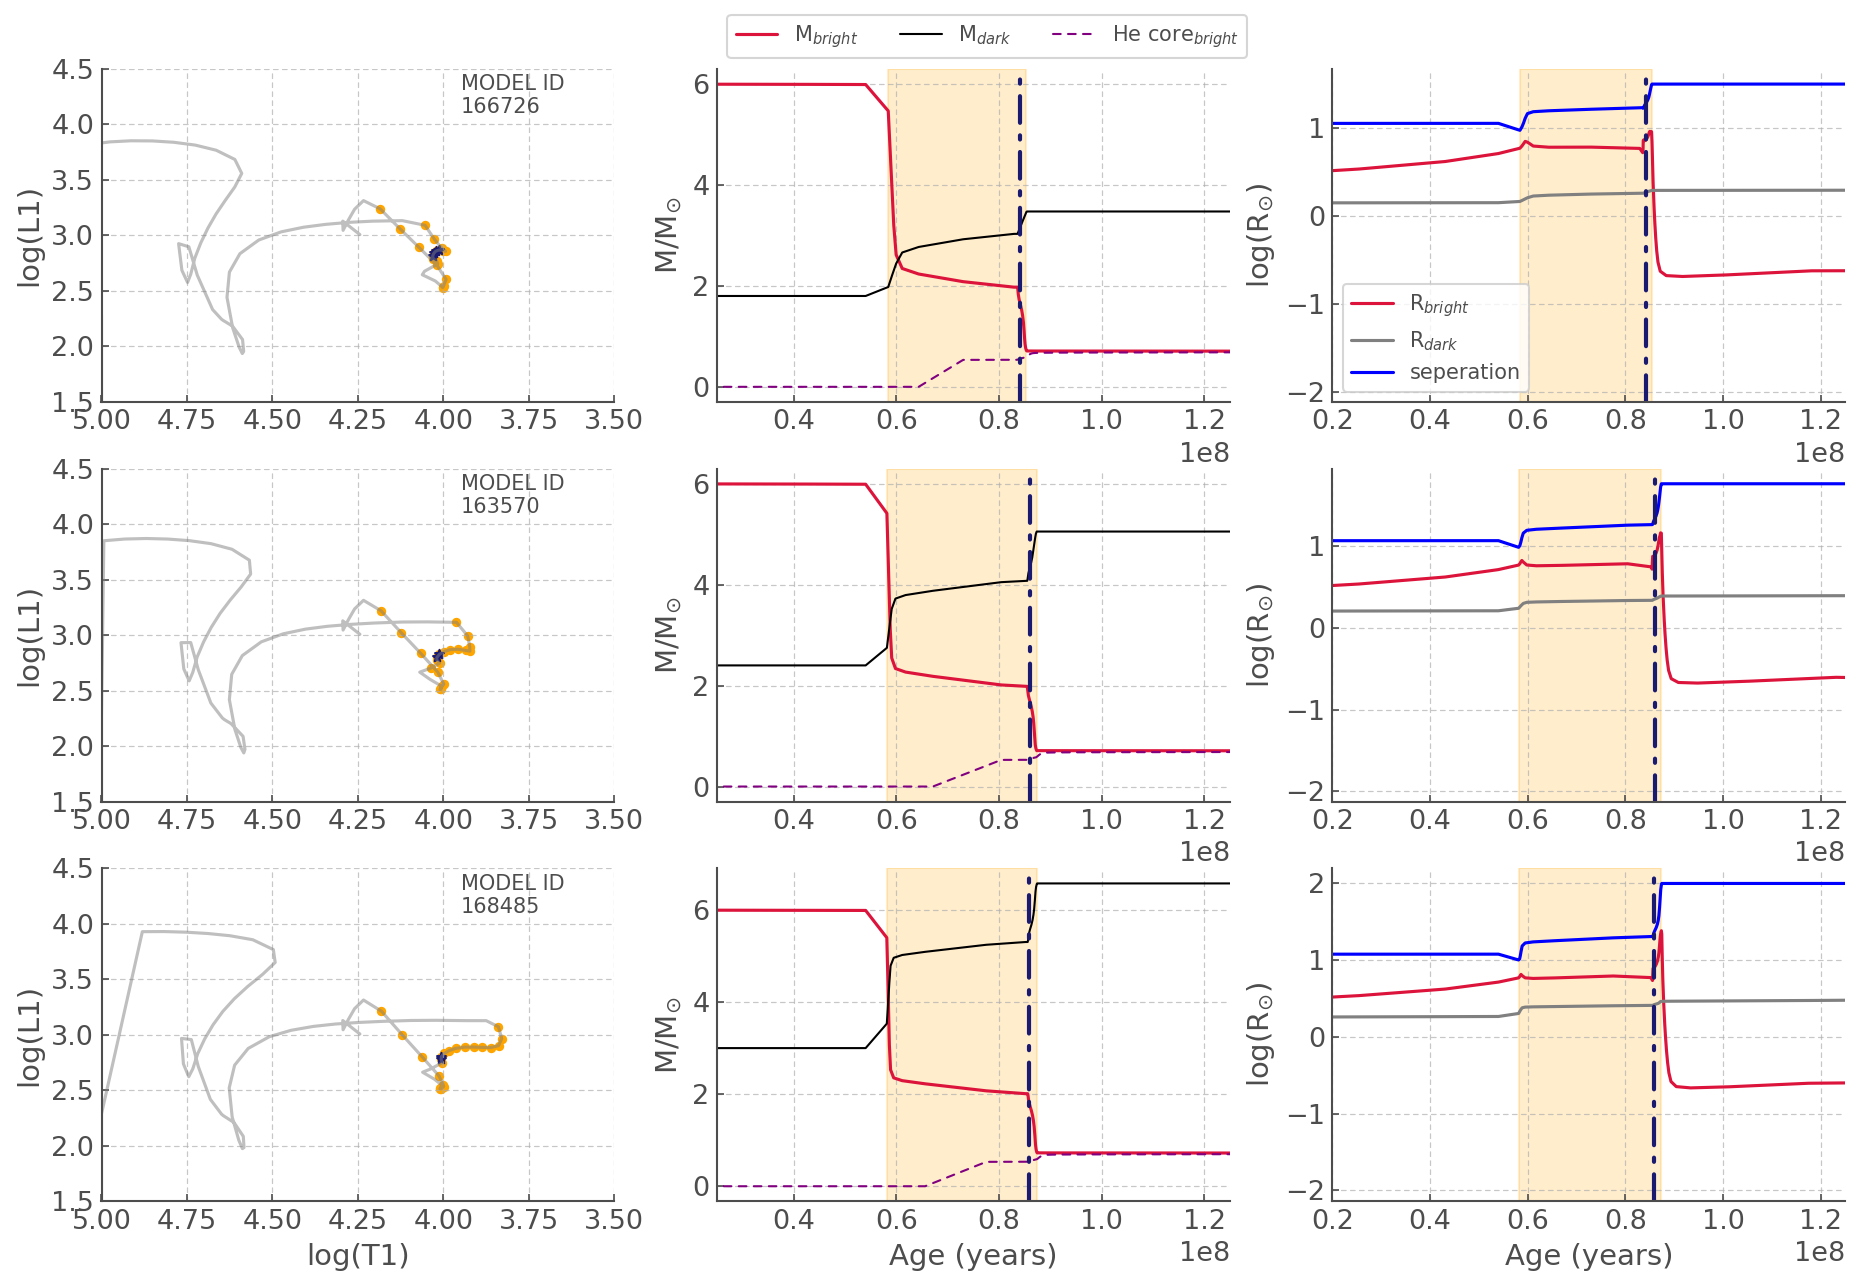

In [26]:
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
ax=ax.reshape(9)
IDs=[166726, 163570,168485]
i=0
for j, match in enumerate(matches_all):
    ax4=ax[i]
    ages = data_search3[data_search3.filenames == match].age.values
    dummy_df=load.dummy_to_dataframe(load.MODELS_PATH+match)
    dummy_df.P_bin*= 365.25
    mt = dummy_df[-dummy_df.DM1R>1e-16] # note this is in msol/year/1.989 (because of STARS code units)
    L = dummy_df['log(L1)'].values
    T = dummy_df['log(T1)'].values
    
    L_match = dummy_df[np.isin(dummy_df.age/1e6, ages)]['log(L1)'].values
    T_match = dummy_df[np.isin(dummy_df.age/1e6, ages)]['log(T1)'].values
    

    ax4.plot(T, L, c='grey', alpha=0.5)

    ax4.scatter(mt['log(T1)'], mt['log(L1)'], color='orange', lw=2)
    ax4.scatter(T_match, L_match, c='midnightblue', alpha=1, marker='*', s=20)
    ax4.set_ylim([ 1.5,4.5])
    ax4.set_xlim([5.0,3.5])

    ax4.set_ylabel('log(L1)')
    ax4.text(3.95, 4.1, f'MODEL ID\n{str(IDs[j])}')
    
    age = dummy_df.age.values
    i+=1
    ax1=ax[i]
    ax1.plot(age, dummy_df.M1, c='crimson', label='M$_{bright}$')
    ax1.plot(age, dummy_df.M2, c='k', lw = 1, label='M$_{dark}$')
    ax1.plot(age, dummy_df['He_core1'], color='purple', ls='--', lw=1, label='He core$_{bright}$')
    ax1.set_ylabel('M/M$_{\odot}$')
    ax1.set_xlim([0.25e8, 1.25e8])
    
    i+=1
    ax2=ax[i]
    ax2.plot(age, dummy_df['log(R1)'], c='crimson', label='R$_{bright}$')
    ax2.plot(age, dummy_df['log(R2)'], c='grey', label='R$_{dark}$')
    ax2.plot(age, dummy_df['log(a)'], c='blue', label='seperation')
    #ax2.plot(age, np.log10(evewiz.dummy_df['P_bin']), c='limegreen', label='Period')
    ax2.set_ylabel('log(R$_{\odot}$)')
    ax2.set_xlim([0.2e8, 1.25e8])
    i+=1
    for axis in [ax1, ax2]:
        axis.axvspan(mt.age.iloc[0],mt.age.iloc[-1], color='orange', alpha=0.2)
        axis.axvline(ages[0]*1e6, color='midnightblue', lw=2,ls='-.', alpha=2)

ax[-3].set_xlabel('log(T1)')
ax[-2].set_xlabel("Age (years)")
ax[-1].set_xlabel("Age (years)")
ax[1].legend(ncol=3, bbox_to_anchor=[0,1])
ax[2].legend()
plt.savefig('best_models_evol.png', dpi=250, bbox_inches='tight')

Finally, for table 3 we once again laod the stellar models in a loop, only recording M1, M2 and the `modelimf` (which is the number of such systems we would expect to encounter in a 1 million solar mass cluster with a single star formation burst)

In [27]:
df_list = []
for j, match in enumerate(matches_all):
    dummy_df=load.dummy_to_dataframe(load.MODELS_PATH+match)
    df_list.append(dummy_df[['M1', 'M2', 'modelimf']].iloc[0])
    
pd.DataFrame(df_list)

,M1,M2,modelimf
0,6.0,1.8,2.875204
0,6.0,2.4,2.784498
0,6.0,3.0,2.716116


### Estimating the brightness of the "dark" component 

The luminosities of the second star sometimes have odd edge cases resulting form the fact that the second star is not fully evolved in detailed by STARS (this will be addressed in BPASSv3) - in this case the secondary has just undergone significant mass transfer and gained a lot of mass rapidly - this means it will have been rejuvinated and have and resamble a ZAMS of its new mass rather than a 100Myr old star. So we check single star models corresponding ot the mass of the secondary and we look at the V band as a proxy (we don't have synthetic spectra for the individual stellar models, they are calculated by BPASS but then discarded after being turned into broad band photometry to make the data size manageable).

In [28]:
data_search3.iloc[1:4][['M2', 'B', 'V','R']]

,M2,B,V,R
785108,3.236406,-2.065517,-1.993789,-1.976508
785109,3.284027,-2.139755,-2.070948,-2.056251
785110,3.321985,-2.200572,-2.136524,-2.125552


In [29]:
sin_166726 = load.dummy_to_dataframe(load.MODELS_PATH+'NEWSINMODS/z010/sneplot-z010-3.3').iloc[0]
sin_166726[['B', 'V','R']]

B    0.167593
V    0.254482
R    0.303433
Name: 0, dtype: float64

In [30]:
data_search3.iloc[2][['B', 'V','R']] - sin_166726[['B', 'V','R']]

B   -2.30735
V   -2.32543
R   -2.35968
dtype: object

So the bright component has V=-2.07 and the dark component has V mag = 0.25. It's not dark but it is >2.3 mag fainter 

In [31]:
data_search3.iloc[4:6][['M2', 'B', 'V','R']]

,M2,B,V,R
785269,4.329369,-2.058397,-1.990123,-1.970666
785270,4.430678,-2.148516,-2.084264,-2.068196


In [32]:
sin_163570 = load.dummy_to_dataframe(load.MODELS_PATH+'NEWSINMODS/z010/sneplot-z010-4.4').iloc[0]
sin_163570[['B', 'V','R']]

B   -0.556777
V   -0.428030
R   -0.357843
Name: 0, dtype: float64

In [33]:
data_search3.iloc[5][['B', 'V','R']] - sin_163570[['B', 'V','R']]

B   -1.59174
V   -1.65623
R   -1.71035
dtype: object

Here we're looking at a 1.5 to 1.7 mag difference (used 4.4 Msol because it's the limiting case) - not qutie as significant but still about 5 times fainter, wouldn't be visible in the spectrum reported. 

In [34]:
data_search3.iloc[6:-1][['M2', 'B', 'V','R']]

,M2,B,V,R
785437,5.467959,-2.124570,-2.058572,-2.039006
785438,5.576845,-2.185328,-2.120004,-2.101651


In [35]:
sin_168485 = load.dummy_to_dataframe(load.MODELS_PATH+'NEWSINMODS/z010/sneplot-z010-5.5').iloc[0]
sin_168485[['B', 'V','R']]

B   -1.089789
V   -0.933029
R   -0.845331
Name: 0, dtype: float64

In [36]:
data_search3.iloc[6][['B', 'V','R']] - sin_168485[['B', 'V','R']]

B   -1.03478
V   -1.12554
R   -1.19368
dtype: object

This is the smallest flux difference with a mag difference of 1.125 (about 3 times fainter)